# 基于K-近邻的车牌号识别
---
## 一.案例介绍
图像的智能处理一直是人工智能领域广受关注的一类技术，代表性的如人脸识别与 CT 肿瘤识别，在人工智能落地的进程中发挥着重要作用。  
其中车牌号识别作为一个早期应用场景，已经融入日常生活中，为我们提供了诸多便利，在各地的停车场和出入口都能看到它的身影。  
车牌号识别往往分为字符划分和字符识别两个子任务，本案例我们将关注字符识别的任务，尝试用 K-NN 的方法对分割好的字符图像进行自动识别和转化。

In [1]:
import os
from PIL import Image
import numpy as np

## 二.数据概览

- 🚦🏍️使用已经分割好的车牌图片作为数据集：  
  包括数字 ***0-9***、字母 ***A-Z*** **（不包含 ***O*** 和 ***I***）** 以及省份简称共 ***65*** 个类，编号从 ***0*** 到 ***64***。  
- 💾🌡️数据已经分成了训练集和测试集，里面的文件夹用 ***label*** 编号命名。  
  一个文件夹下的所有图片都属于该文件夹对应的类，每个图片都是 ***20 * 20*** 的二值化灰度图。  
  
✔️⚙️借助 ***PIL*** 库将图片转化为向量：

In [2]:
img = Image.open('data/train/0/4-3.jpg')  # 打开图片
img  # 显示图片

In [3]:
pixels = np.array(img)  # 转化为 numpy 矩阵
pixels.shape

(20, 20)

## 三.图像像素以及标签提取

- **训练集数据**："./data/train/" 📂路径下 ***15954*** 张图片📸
- **测试集数据**："./data/test/"  📂路径下 ***4665***  张图片🖼️

In [4]:
'''
函数说明：
Parameters:
    files_path - 数据存储路径("./data/train/"训练集)("./data/test/"测试集)
Returns:
    data_array - 图像数组，每一个图像转化为(1,400)的向量
    labels_array - 标签数组(0,64)共65类
'''
def dataSet(files_path):
    data_list=[] # 数据列表
    labels=[] # 标签列表
    # 根据路径读取图片
    label_list=os.listdir(files_path)
    for label in label_list:
        file_path=os.path.join(files_path,label)
        image_list=os.listdir(file_path)
        for image in image_list:
            image_path=os.path.join(file_path,image)
            # 打开图片
            img = Image.open(image_path)
            # 转化为 numpy 矩阵 (20,20)
            pixels = np.array(img)
            # 转化为 vector 向量 (400)
            column=pixels.shape[0]*pixels.shape[1]
            data_list.append(pixels.reshape(column))
            labels.append(int(label))
    # 转化为 array 数组 (numsample,400)
    data_array=np.array(data_list)
    labels_array=np.array(labels)
    return data_array,labels_array

In [5]:
# 分别读入图片数据，训练集和测试集分别在两个路径
data_train,labels_train=dataSet("./data/train/")
data_test,labels_test=dataSet("./data/test/")

In [6]:
# 显示训练集第一条像素数组和标签
print(data_train[0])
print(labels_train[0])
# 显示训练集数组维度类型
print(data_train.shape)
print(labels_train.shape)

[  1   0   1   0   0   2  26 139 254 255 254 254 141  27   1   2   0   0
   0   0   0   2   2   0   1  95 254 255 255 250 253 255 250 253  27   0
   0   0   0   0   0   3   0   0 119 255 251 190 126 128 131 162 255 254
 140   0   0   0   0   0   0   0   2   4 229 252 203  39   0   1   0  23
 166 251 255   3   0   0   0   0   3   0   1   0 229 255 177   1   0   8
   0   1 130 253 255   0   0   0   0   0   0   2   4   0 232 252 182   0
   3   0   2   1 126 255 252 233   0   0   0   0   3   3   0   4 227 254
 182   3   0   1   0   2 122 255 255 230   0   0   0   0   0   0   5   0
 229 255 176   0   0   2   0   0  64 219 254 227   0   0   0   0   0   0
   1   0 230 254 180   0   5   0   1   0   0 180 254 229   0   0   0   0
   0   0   1   1 228 253 179   2   0   7   1   0 119 247 253 232   0   0
   0   0   1   1   0   1 230 254 176   0   2   1   0   5 127 254 253 231
   0   0   0   0   1   1   0   0 231 253 177   1   0   2   0   0  91 233
 255 229   0   0   0   0   0   0   1   0 230 252 18

In [7]:
# 显示测试集第一条像素数组和标签
print(data_test[0])
print(labels_test[0])
# 显示测试集数组维度类型
print(data_test.shape)
print(labels_test.shape)

[  0   0   0   0   0   0   6  30  64  80  78  75  69  45  20   2   0   3
   0   0   0   1   0   3   7  73 190 242 248 255 255 255 255 242 216 116
  43   6   0   0   0   0   0  14 131 244 255 247 243 192 154 154 199 239
 254 253 220  94   4   4   0   1  23 149 249 254 234 110   0   0   4   0
   0  19 137 242 255 239  77   0   0   1  81 236 253 241 130   8   0   1
   0   2   0   0  48 202 255 253 198   2   3   0  88 236 254 241 119   0
   0   0   3   0   2   0  27 169 253 254 198   5   0   0  91 248 255 245
 127   0   2   0   0   3   0   0  11 139 251 255 210  21   1   1 110 255
 255 231  95   2   0   0   1   0   1   2  22 168 253 255 226  41   1   1
  98 247 255 236 105   1   1   0   1   1   0   0  35 176 254 254 205  12
   0   2 116 251 255 243 121   0   0   0   0   0   2   0  15 150 251 254
 206  15   0   1 110 254 253 245 130   1   0   2   0   0   0   2  45 201
 254 255 215  29   3   0 109 255 254 227  94   1   1   0   0   1   2   0
  43 187 253 255 198   3   0   6 133 255 254 243 12

## 四.模型构建

### 🧰***sklearn*** 实现，***sklearn.neighbors.KNeighborsClassifier*** 
`(class) KNeighborsClassifier(n_neighbors: int = 5, weights: str = "uniform", algorithm: str = "auto", leaf_size: int = 30, p: int = 2, metric: str = "minkowski")`
- ***n_neighbors***：默认为5，就是k-NN的k的值，选取最近的k个点。
- ***weights***：默认是uniform，参数可以是uniform、distance，也可以是用户自己定义的函数。  
  uniform是均等的权重，就说所有的邻近点的权重都是相等的。  
  distance是不均等的权重，距离近的点比距离远的点的影响大。  
  用户自定义的函数，接收距离的数组，返回一组维数相同的权重。
- ***algorithm***：快速k近邻搜索算法，默认参数为auto，可以理解为算法自己决定合适的搜索算法。  
  除此之外，用户也可以自己指定搜索算法ball_tree、kd_tree、brute方法进行搜索，brute是蛮力搜索，也就是线性扫描，当训练集很大时，计算非常耗时。  
  kd_tree，构造kd树存储数据以便对其进行快速检索的树形数据结构，kd树也就是数据结构中的二叉树。以中值切分构造的树，每个结点是一个超矩形，在维数小于20时效率高。  
  ball tree是为了克服kd树高纬失效而发明的，其构造过程是以质心C和半径r分割样本空间，每个节点是一个超球体。
- ***leaf_size***：默认是30，这个是构造的kd树和ball树的大小。  
  这个值的设置会影响树构建的速度和搜索速度，同样也影响着存储树所需的内存大小。需要根据问题的性质选择最优的大小。
- ***metric***：用于距离度量，默认度量是minkowski，也就是p=2的欧氏距离(欧几里德度量)。
- ***p***：距离度量公式，这个参数默认为2，也就是默认使用欧式距离公式进行距离度量。  
  也可以设置为1，使用曼哈顿距离公式进行距离度量。

In [8]:
from sklearn.neighbors import KNeighborsClassifier
'''
函数说明: KNN欧氏距离sklearn模型构建
Parameters:
    data_train - 训练集像素数组
    labels_train - 训练集标签
    data_test - 测试集像素数组
    k - K-values
Returns:
    classResult - 预测标签
'''
def KNNtest(data_train,labels_train,data_test,k):
    KNN=KNeighborsClassifier(n_neighbors = k, algorithm = 'auto')
    KNN.fit(data_train,labels_train)
    classResult=KNN.predict(data_test)
    return classResult

### ♟️扩展：**自主** 实现, **K-近邻欧氏距离模型**
- 🧠***k***-**近邻**算法 ***(k-nearest neighbor, k-NN)***
  1. 计算已知类别数据集中的点与当前点之间的距离；
  2. 按照距离递增次序排序；
  3. 选取与当前点距离最小的 ***k*** 个点；
  4. 确定前 ***k*** 个点所在类别的出现频率；
  5. 返回前 ***k*** 个点所出现频率最高的类别作为当前点的预测分类。
- 📐距离度量 **(欧几里得距离)**
  - 📌 $d_{ij}=\sqrt{\sum_{k=1}^{p} {(x_{ik}-x_{jk})^2}}$ 📌
- 💾数据归一化 ***(normalization)***
  - $NORMdata=(data-min)/(max-min)$
  - 📢数据未进行归一化处理训练的模型效果差❗❗❗

In [9]:
import operator
# K-近邻欧氏距离模型
class K_NN:
    def __init__(self,Kvalue=5,distance='eucl') -> None:
        self.Kvalue=Kvalue # kNN算法参数,选择距离最小的k个点，默认5
        self.distance=distance # 距离度量方法，默认欧氏距离

    '''
    函数说明：分类器
    Parameters:
        x - 训练集features
        y - 训练集labels
        x_test - 测试集features
    Returns:
        classResult - 分类结果
    '''
    def classify(self,x,y,x_test):
        '''
        函数说明：欧氏距离
        Parameters:
            x - 训练集features
            x_test_each - 测试集features单条样本
        Returns:
            distances - 距离数组
        '''
        def Euclidean_distance(x,x_test_each):
            x_sample_num = x.shape[0] # 样本数量
            # 构造矩阵：np.tile()
            # 在列向量方向上重复 x_test_each 共 1 次(横向)
            # 行向量方向上重复 x_test_each 共 x_sample_num 次(纵向)
            diffMat = np.tile(x_test_each,(x_sample_num,1)) - x # 相减
            sqDiffMat = diffMat**2 # 平方
            # sum()所有元素相加,sum(0)列相加,sum(1)行相加
            sqDistances = sqDiffMat.sum(axis=1) # 求和
            distances = sqDistances**0.5 # 开方
            return distances
        
        '''
        函数说明: 预测,前K最小距离类别频数最大的作为分类结果
        Parameters:
            distances - 距离数组
        Returns:
            sortedClassCount[0][0] - 分类结果
        '''
        def predict(distances):
            # 返回distances中元素从小到大排序后的索引值
            sortedDistIndices = distances.argsort()
            # 定一个记录类别次数的字典
            classCount = {}
            for i in range(self.Kvalue):
                # 取出前k个元素的类别
                voteIlabel = y[sortedDistIndices[i]]
                # dict.get(key,default=None),字典的get()方法,返回指定键的值,如果值不在字典中返回默认值。
                # 计算类别次数
                classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
            # key=operator.itemgetter(1)根据字典的值进行排序
            # key=operator.itemgetter(0)根据字典的键进行排序
            # reverse降序排序字典
            sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
            return sortedClassCount[0][0]
            
        if self.distance=='eucl':
            classResult=[]
            for x_test_each in x_test:
                distances=Euclidean_distance(x,x_test_each)
                yp=predict(distances)
                classResult.append(yp)
        elif 1:
            pass # 可扩展其他距离度量
        return classResult
   

In [10]:
'''
函数说明：数据归一化
Parameters:
    dataSet - 原始数据
Returns:
    normDataSet - 归一化数据
'''
def normdata(dataSet):
    # 获得数据的最小值
    minVals = dataSet.min(0)
    maxVals = dataSet.max(0)
    # 最大值和最小值的范围
    ranges = maxVals - minVals
    # shape(dataSet)返回dataSet的矩阵行列数
    normDataSet = np.zeros(np.shape(dataSet))
    # 返回dataSet的行数
    m = dataSet.shape[0]
    # 原始值减去最小值
    normDataSet = dataSet - np.tile(minVals, (m, 1))
    # 除以最大和最小值的差,得到归一化数据
    normDataSet = normDataSet / np.tile(ranges, (m, 1))
    return normDataSet
        
'''
函数说明: K-近邻欧氏距离模型构建
Parameters:
    data_train - 训练集像素数组
    labels_train - 训练集标签
    data_test - 测试集像素数组
    k - K-values
Returns:
    classResult - 预测标签
'''
def K_NNtest(data_train,labels_train,data_test,k):
    K_NNclassifier=K_NN(Kvalue = k, distance = 'eucl')
    classResult=K_NNclassifier.classify(data_train,labels_train,data_test)
    return classResult

### 🎭扩展：***Manhattan Distance*** ***K-NN***
- 📐距离度量 **(曼哈顿距离)**
  - 📌 $d(i,j)=\sum_{k=1}^{p} {|(x_{k}(i)-x_{k}(j))|}$ 📌

In [11]:
from sklearn.neighbors import KNeighborsClassifier
'''
函数说明: KNN曼哈顿距离sklearn模型构建
Parameters:
    data_train - 训练集像素数组
    labels_train - 训练集标签
    data_test - 测试集像素数组
    k - K-values
Returns:
    classResult - 预测标签
'''
def KNNtest_MD(data_train,labels_train,data_test,k):
    KNN_MD=KNeighborsClassifier(n_neighbors = k, algorithm = 'auto', p = 1 )
    KNN_MD.fit(data_train,labels_train)
    classResult=KNN_MD.predict(data_test)
    return classResult

### 🎭扩展：**加权** ***K-NN*** 
- 👣属性加权:  
  ***distance*** 是不均等的权重，距离近的点比距离远的点的影响大。  
  - 📌 $d_{WE}(i,j)=[\sum_{k=1}^{p} {W_k(x_{ik}-x_{jk})^2}]^\frac{1}{2}$ 📌  

In [12]:
from sklearn.neighbors import KNeighborsClassifier
'''
函数说明: KNN加权sklearn模型构建
Parameters:
    data_train - 训练集像素数组
    labels_train - 训练集标签
    data_test - 测试集像素数组
    k - K-values
Returns:
    classResult - 预测标签
'''
def KNNtest_WE(data_train,labels_train,data_test,k):
    KNN_WE=KNeighborsClassifier(n_neighbors = k, weights = "distance", algorithm = 'auto')
    KNN_WE.fit(data_train,labels_train)
    classResult=KNN_WE.predict(data_test)
    return classResult

## 五.对比当 K 取不同值对模型效果的影响

测试 ***K-values*** 从 ***1*** 到 ***10*** 对模型效果的影响：

- 🎨画出了 ***K-values*** 对模型的影响变化  
  准确率 ***Accuracy***  

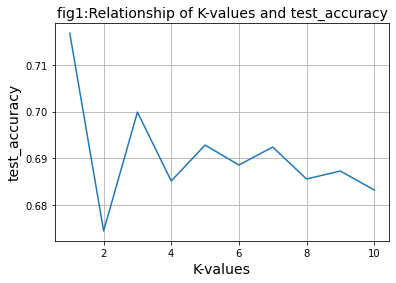

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# sklearn
acc_list=[]
for k in range(1,11):
    classResult=KNNtest(data_train,labels_train,data_test,k)
    acc_list.append(accuracy_score(classResult,labels_test))

plt.figure()
plt.plot(range(1,11), acc_list)
plt.title('fig1:Relationship of K-values and test_accuracy',fontsize=14)
plt.xlabel('K-values',fontsize=14)
plt.ylabel('test_accuracy',fontsize=14)
plt.grid(True)
plt.show()

🧰***sklearn*** 实现分析👆👆👆   
***K*** 取 ***1*** 时准确率较高，随着 ***K*** 的增大准确率降低

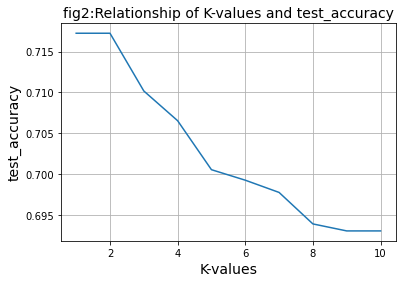

In [14]:
# 数据归一化
normd=normdata(data_train)
normd_test=normdata(data_test)
# K-近邻欧氏距离模型(自主实现)
acc_list=[]
for k in range(1,11):
    classResult=K_NNtest(normd,labels_train,normd_test,k)
    acc_list.append(accuracy_score(classResult,labels_test))

plt.figure()
plt.plot(range(1,11), acc_list)
plt.title('fig2:Relationship of K-values and test_accuracy',fontsize=14)
plt.xlabel('K-values',fontsize=14)
plt.ylabel('test_accuracy',fontsize=14)
plt.grid(True)
plt.show()

♟️扩展 **自主** 实现分析👆👆👆  
***K*** 取 ***1*** 时准确率较高，随着 ***K*** 的增大准确率降低

## 六.测试集分类结果分析

- 根据 ***fig1*** : ***K*** 取 ***1*** 训练 ***sklearn*** 模型💯  
准确率 ***Accuracy***  
- 🎭扩展分析：
  - 对比 **不同距离度量方式** 对模型效果的影响
    - 欧氏距离 : 曼哈顿距离
  - 对比 **属性权重** 对模型效果的影响
    - 平权 : 加权

In [15]:
# sklearn模型准确率
for k in range(1,11):
    classResult=KNNtest(data_train,labels_train,data_test,k)
    acc=accuracy_score(classResult,labels_test)
    print("sklearn模型,[欧氏距离  ,平权,k=%d],准确率---> " %k,acc)

    classResult=KNNtest_MD(data_train,labels_train,data_test,k)
    acc=accuracy_score(classResult,labels_test)
    print("sklearn模型,[曼哈顿距离,平权,k=%d],准确率---> " %k,acc)

    classResult=KNNtest_WE(data_train,labels_train,data_test,k)
    acc=accuracy_score(classResult,labels_test)
    print("sklearn模型,[欧氏距离  ,加权,k=%d],准确率---> " %k,acc)
    
    print("--------------------------------------------------------------")

sklearn模型,[欧氏距离  ,平权,k=1],准确率--->  0.7168274383708467
sklearn模型,[曼哈顿距离,平权,k=1],准确率--->  0.7144694533762058
sklearn模型,[欧氏距离  ,加权,k=1],准确率--->  0.7168274383708467
--------------------------------------------------------------
sklearn模型,[欧氏距离  ,平权,k=2],准确率--->  0.6743837084673098
sklearn模型,[曼哈顿距离,平权,k=2],准确率--->  0.6726688102893891
sklearn模型,[欧氏距离  ,加权,k=2],准确率--->  0.7168274383708467
--------------------------------------------------------------
sklearn模型,[欧氏距离  ,平权,k=3],准确率--->  0.69989281886388
sklearn模型,[曼哈顿距离,平权,k=3],准确率--->  0.6906752411575563
sklearn模型,[欧氏距离  ,加权,k=3],准确率--->  0.7103965702036441
--------------------------------------------------------------
sklearn模型,[欧氏距离  ,平权,k=4],准确率--->  0.685101822079314
sklearn模型,[曼哈顿距离,平权,k=4],准确率--->  0.6782422293676313
sklearn模型,[欧氏距离  ,加权,k=4],准确率--->  0.7078242229367632
--------------------------------------------------------------
sklearn模型,[欧氏距离  ,平权,k=5],准确率--->  0.6928188638799572
sklearn模型,[曼哈顿距离,平权,k=5],准确率--->  0.6827438370846731


- 根据 ***fig2*** : ***K*** 取 ***1*** 训练 **自主实现** 模型💯  
准确率 ***Accuracy***  
📢由于归一化处理数据的结果，准确率相较sklearn有微小提高❗❗❗

In [16]:
# 自主实现模型准确率
classResult=K_NNtest(normd,labels_train,normd_test,k=1)
acc=accuracy_score(classResult,labels_test)
print("自主实现模型,[欧氏距离  ,平权,k=1],准确率---> ",acc)

自主实现模型,[欧氏距离  ,平权,k=1],准确率--->  0.7172561629153269
